In [2]:
import torch

# Verifica si CUDA (GPU) está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')


# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

C:\Users\luisl\AppData\Local\Temp\ipykernel_5484\269888456.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [5]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [6]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

## Load and process input data

Check the texts which is filtered by keyword as well

In [7]:
import pickle
import os

# Rutas de los archivos
ruta_original = 'C:/Users/Luis/Desktop/personal/tfm_ia3_nodata/data/preprocessed/'
ruta_nueva = 'C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/data/preprocessed/'
archivos = ['text_no_split.pickle', 'text_keyword.pickle']

# Intentar cargar los archivos
text_no_split = None
text_keyword = None

for archivo in archivos:
    try:
        # Intenta abrir el archivo en la ruta original
        with open(os.path.join(ruta_original, archivo), 'rb') as file:
            if archivo == 'text_no_split.pickle':
                text_no_split = pickle.load(file)
            elif archivo == 'text_keyword.pickle':
                text_keyword = pickle.load(file)
        print(f"Archivo {archivo} encontrado en la ruta original.")
    except FileNotFoundError:
        try:
            # Si no se encuentra en la ruta original, intenta en la nueva
            with open(os.path.join(ruta_nueva, archivo), 'rb') as file:
                if archivo == 'text_no_split.pickle':
                    text_no_split = pickle.load(file)
                elif archivo == 'text_keyword.pickle':
                    text_keyword = pickle.load(file)
            print(f"Archivo {archivo} encontrado en la nueva ruta.")
        except FileNotFoundError:
            print(f"Archivo {archivo} no encontrado en ninguna de las rutas.")

# Usar las variables text_no_split y text_keyword según sea necesario.


Archivo text_no_split.pickle encontrado en la nueva ruta.
Archivo text_keyword.pickle encontrado en la nueva ruta.


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


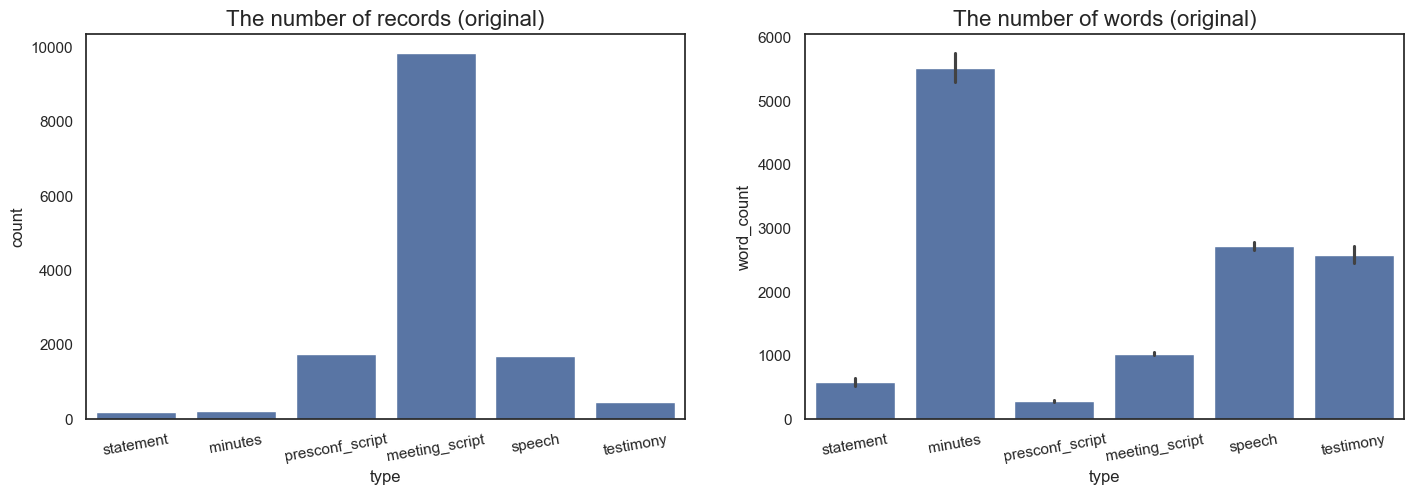

In [8]:
# Check the number of records per document type
def plot_num_rec_word(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    sns.countplot(x='type', data=df, ax=ax1)
    ax1.set_title('The number of records (original)', fontsize=16)
    ax1.tick_params('x', labelrotation=10)
    sns.barplot(data=df, x='type', y='word_count', ax=ax2)
    ax2.set_title('The number of words (original)', fontsize=16)
    ax2.tick_params('x', labelrotation=10)

# All texts
plot_num_rec_word(text_no_split)
text_no_split.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1,4.25,1994-07-06,0,4.25,The Board approved an increase in the discount...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1,5.50,1994-12-20,0,5.50,"In a related move, the Federal Open Market Com..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,403,-1,5.25,1996-03-26,0,5.25,For immediate releaseThe Federal Reserve today...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,432,1,5.50,1997-05-20,0,5.50,For immediate release\tThe Federal Open Market...
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,400,-1,5.25,1998-10-15,-1,5.00,For immediate releaseThe Federal Open Market C...


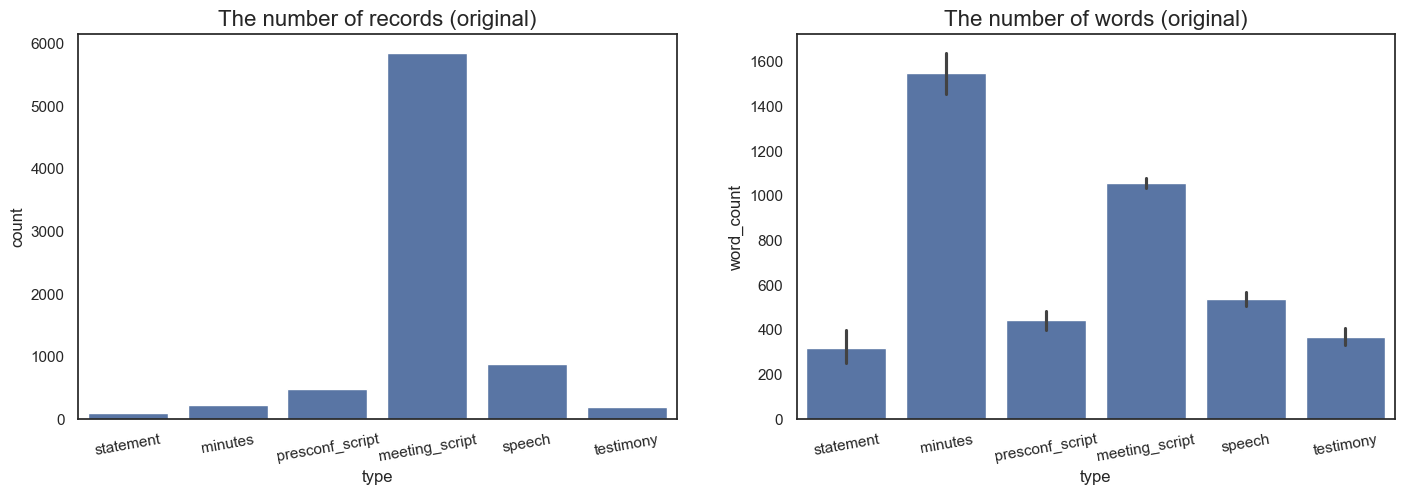

In [9]:
# Filtered by keywords
plot_num_rec_word(text_keyword)
text_keyword.head()

In [10]:
# # Drop meeting script data
# text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
# text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
# text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

### Select text dataframe
Here, use all the texts but keywords filtere one would give better performance - to be checked.

(4339, 11)


  0%|          | 0/9852 [00:00<?, ?it/s]

(4597, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


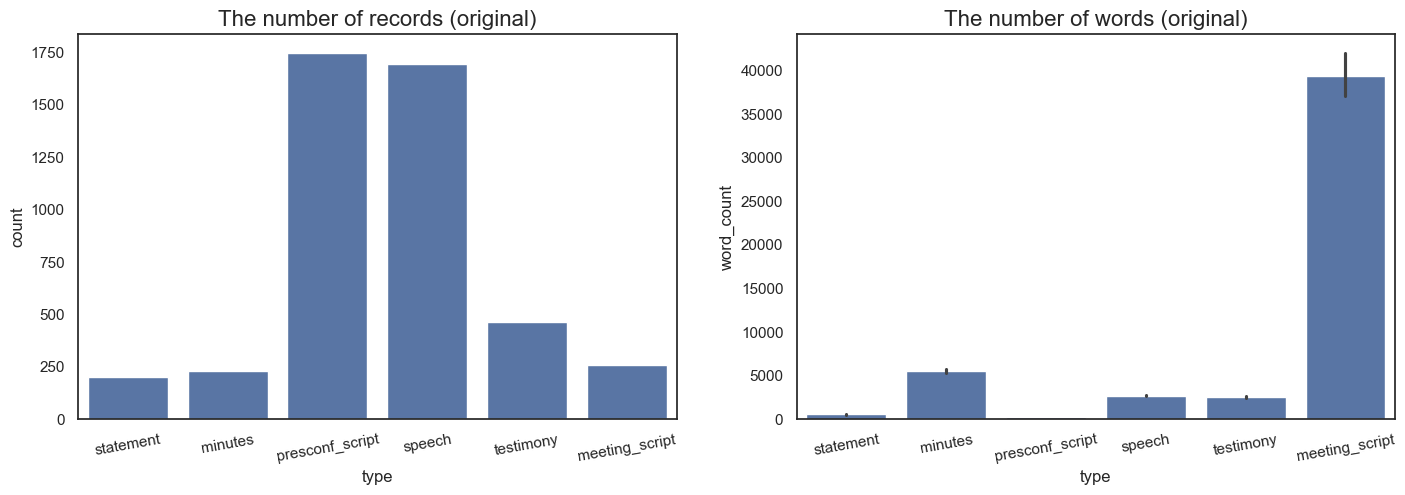

In [11]:
def combine_meeting_script(df):
    new_df = df.loc[df['type'] != 'meeting_script']
    print(new_df.shape)
    meeting_script_df = df.loc[df['type'] == 'meeting_script'].reset_index(drop=True)
    data_list = []
    for i, row in tqdm(meeting_script_df.iterrows(), total=meeting_script_df.shape[0]):
        if i == 0:
            prev_row = row
            continue
        if prev_row['date'].strftime('%Y-%m-%d') == row['date'].strftime('%Y-%m-%d'):
            prev_row['text'] = prev_row['text'] + row['text']
        else:
            prev_row['speaker'] = ""
            prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
            data_list.append(list(prev_row))
            prev_row = row

    prev_row['speaker'] = ""
    prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
    data_list.append(list(prev_row))
    new_meeting_script_df = pd.DataFrame(data_list, columns=df.columns)
    new_df = pd.concat([new_df, new_meeting_script_df], axis=0)
    print(new_df.shape)
    return new_df

train_df = combine_meeting_script(text_no_split)
plot_num_rec_word(train_df)
train_df.head()

In [12]:
train_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


In [13]:
# Calcular el número total de filas en el DataFrame
num_total_filas = train_df.shape[0]

print("Número total de filas en el DataFrame:", num_total_filas)

Número total de filas en el DataFrame: 4597


In [14]:
# Supongamos que tienes un DataFrame llamado df y una variable específica llamada 'variable_especifica'
variable_especifica = 'next_decision'

# Contar el número de filas con valores NaN en la variable especificada
num_filas_nan = train_df[variable_especifica].isnull().sum()

print("Número de filas con NaN en la variable '{}': {}".format(variable_especifica, num_filas_nan))


Número de filas con NaN en la variable 'next_decision': 31


In [15]:
# Filtrar el DataFrame para seleccionar solo las filas con valores NaN en la variable especificada
filas_nan = train_df[train_df[variable_especifica].isnull()]

# Obtener los valores de la columna "date" correspondientes a las filas con valores NaN
fechas_nan = filas_nan['date']

print("Valores de 'date' correspondientes a filas con NaN en la variable '{}':".format(variable_especifica))
print(fechas_nan)

Valores de 'date' correspondientes a filas con NaN en la variable 'next_decision':
201    2023-12-13
2151   2023-12-13
2152   2023-12-13
2153   2023-12-13
2154   2023-12-13
2155   2023-12-13
2156   2023-12-13
2157   2023-12-13
2158   2023-12-13
2159   2023-12-13
2160   2023-12-13
2161   2023-12-13
2162   2023-12-13
2163   2023-12-13
2164   2023-12-13
2165   2023-12-13
2166   2023-12-13
2167   2023-12-13
2168   2023-12-13
2169   2023-12-13
2170   2023-12-13
2171   2023-12-13
2172   2023-12-13
2173   2023-12-13
2174   2023-12-13
2175   2023-12-13
2176   2023-12-13
2177   2023-12-13
2178   2023-12-13
2179   2023-12-13
2180   2023-12-13
Name: date, dtype: datetime64[ns]


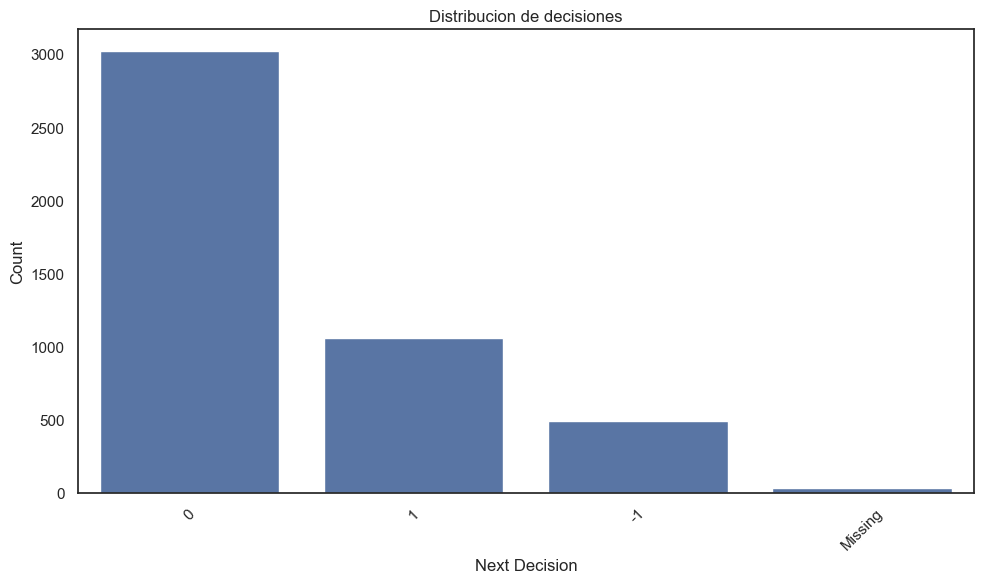

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
train_df['next_decision'] = train_df['next_decision'].fillna('Missing')
# Crear el gráfico de conteo
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='next_decision')

# Añadir etiquetas y título
plt.xlabel('Next Decision')
plt.ylabel('Count')
plt.title('Distribucion de decisiones')

# Mostrar el gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor claridad
plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
plt.show()

c:\Users\luisl\anaconda3\envs\tfm_modelado\lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


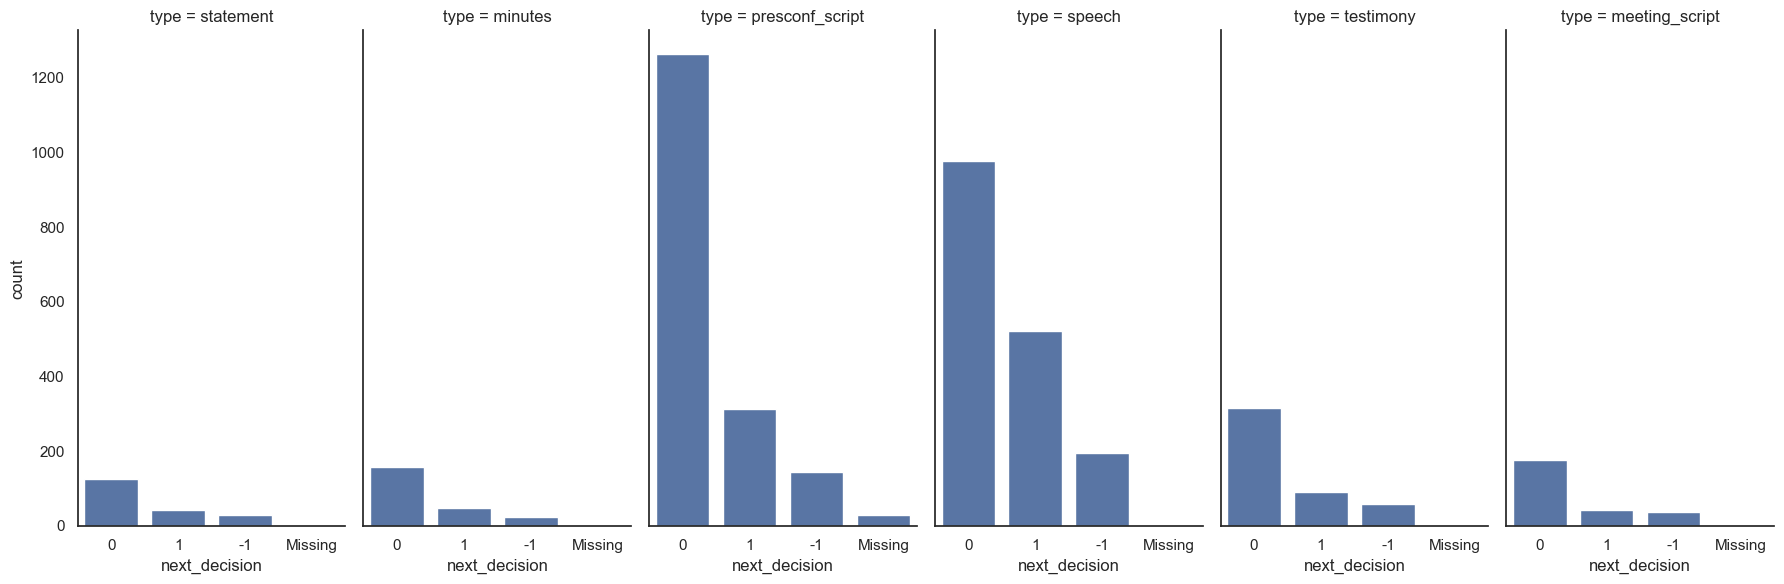

In [17]:
# Check balance of Rate Decision
train_df['next_decision'] = train_df['next_decision'].fillna('Missing')
g = sns.FacetGrid(train_df, col='type', height=6, aspect=0.5)
g.map(sns.countplot, 'next_decision')
plt.show()


C:\Users\luisl\AppData\Local\Temp\ipykernel_5484\4191536359.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
C:\Users\luisl\AppData\Local\Temp\ipykernel_5484\4191536359.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn

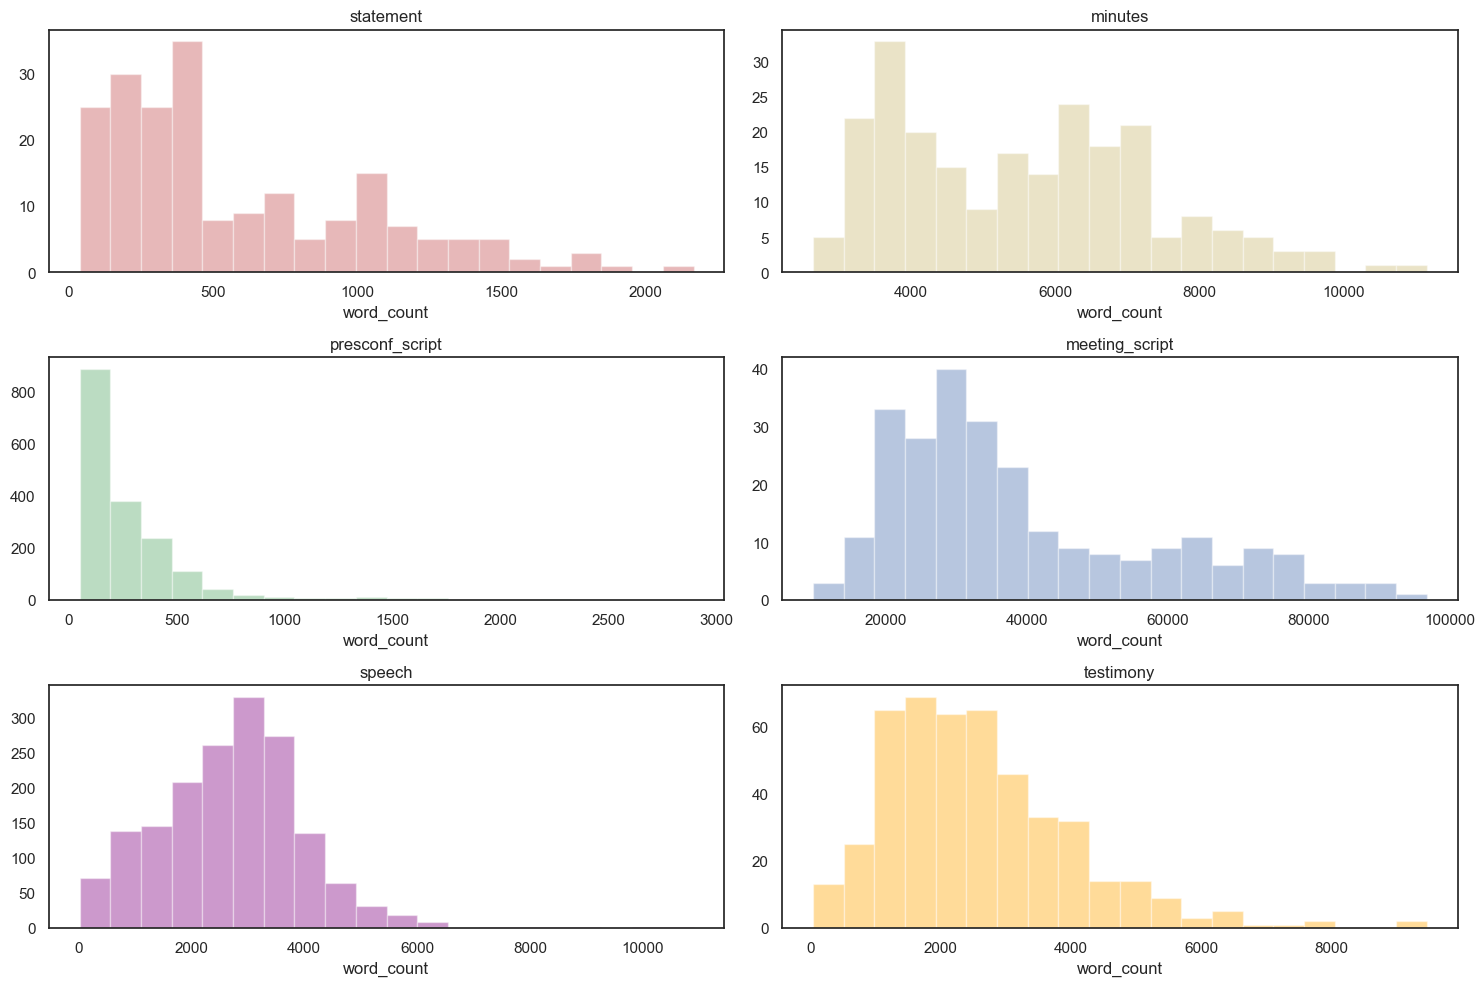

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
253,meeting_script,2014-04-30,FOMC Meeting Transcript,,78299,0,0.0,2014-06-18,0,0.0,"Good morning, everybody. Unfortunately, this i..."
254,meeting_script,2014-06-18,FOMC Meeting Transcript,,87191,0,0.0,2014-07-30,0,0.0,I'd like to begin by welcoming three people to...
255,meeting_script,2014-07-30,FOMC Meeting Transcript,,89115,0,0.0,2014-09-17,0,0.0,"Good morning, everybody. I would like to begin..."
256,meeting_script,2014-09-17,FOMC Meeting Transcript,,61267,0,0.0,2014-10-29,1,0.0,"Good morning, everybody.Our first two items th..."
257,meeting_script,2014-10-29,FOMC Meeting Transcript,,72330,1,0.0,2014-12-17,0,0.0,I'd like to call this meeting to order. Before...


In [18]:
# Check distribution
def plot_distribution(df, kde):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,10))
    doc_type = 'statement'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
    ax1.set_title(doc_type)
    doc_type = 'minutes'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=kde, color='y')
    ax2.set_title(doc_type)
    doc_type = 'presconf_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=kde, color='g')
    ax3.set_title(doc_type)
    doc_type = 'meeting_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=kde, color='b')
    ax4.set_title(doc_type)
    doc_type = 'speech'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=kde, color='purple')
    ax5.set_title(doc_type)
    doc_type = 'testimony'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax6, kde=kde, color='orange')
    ax6.set_title(doc_type)

    fig.tight_layout(pad=1.0)
    plt.show()

plot_distribution(train_df, False)
train_df.tail()


## Split each text by sentence

In [19]:
"""

# Add a key for aggregation
train_df['key'] = train_df.index.get_level_values(0)
train_df.head()

# Split the data by sentence
def split_df(df, text_column='text'):
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        text_list = sent_tokenize(row[text_column])
        for text in text_list:
            new_row = row.copy()
            new_row[text_column] = text
            new_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(new_row))

    split_df = pd.DataFrame(split_data_list, columns=df.columns)

    # Convertir valores 'Missing' o similares a NaN, y después a tipo numérico
    for column in ['decision', 'next_decision']:
        split_df[column] = pd.to_numeric(split_df[column], errors='coerce')

    # Opcional: Eliminar filas donde 'next_decision' es NaN
    #split_df = split_df.dropna(subset=['next_decision'])

    # La conversión a 'Int8' ahora debería ser segura dado que hemos manejado valores no numéricos
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

    return split_df
train_sent_df = split_df(train_df)
print(train_sent_df.shape)

"""

"\n\n# Add a key for aggregation\ntrain_df['key'] = train_df.index.get_level_values(0)\ntrain_df.head()\n\n# Split the data by sentence\ndef split_df(df, text_column='text'):\n    split_data_list = []\n\n    for i, row in tqdm(df.iterrows(), total=df.shape[0]):\n        text_list = sent_tokenize(row[text_column])\n        for text in text_list:\n            new_row = row.copy()\n            new_row[text_column] = text\n            new_row['word_count'] = len(re.findall(r'\x08([a-zA-Z]+n't|[a-zA-Z]+'s|[a-zA-Z]+)\x08', text))\n            split_data_list.append(list(new_row))\n\n    split_df = pd.DataFrame(split_data_list, columns=df.columns)\n\n    # Convertir valores 'Missing' o similares a NaN, y después a tipo numérico\n    for column in ['decision', 'next_decision']:\n        split_df[column] = pd.to_numeric(split_df[column], errors='coerce')\n\n    # Opcional: Eliminar filas donde 'next_decision' es NaN\n    #split_df = split_df.dropna(subset=['next_decision'])\n\n    # La conversi

In [20]:
"""

# Check distribution
plot_distribution(train_sent_df, False)
train_sent_df.tail()

"""

'\n\n# Check distribution\nplot_distribution(train_sent_df, False)\ntrain_sent_df.tail()\n\n'

## Load a trained model

In [21]:

train_sent_df = train_df[train_df['type'] != 'meeting_script']

In [22]:
train_sent_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


In [23]:
train_sent_df.shape

(4339, 11)

In [24]:
# Supongamos que quieres contar los NaN en la columna 'next_decision' de train_sent_df
nans_count = train_sent_df['next_decision'].isna().sum()

print(f"Número de valores NaN en la columna 'next_decision': {nans_count}")


Número de valores NaN en la columna 'next_decision': 0


In [25]:
train_sent_df = train_sent_df.dropna(subset=['next_decision'])
train_sent_df.shape

(4339, 11)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

In [31]:

import pandas as pd

def equilibrar_columna_ignorando_missing(df, columna, valor_missing='Missing'):
    """
    Equilibra los valores en una columna específica de un DataFrame de pandas,
    ignorando los valores faltantes.
    
    Parámetros:
    - df: DataFrame de pandas.
    - columna: Nombre de la columna a equilibrar.
    - valor_missing: Valor que representa los datos faltantes en la columna.
    
    Retorna:
    - DataFrame equilibrado donde cada valor único en la columna especificada
      (excepto el valor_missing) tiene el mismo número de filas.
    """
    # Filtra los valores faltantes
    df_filtrado = df[df[columna] != valor_missing]
    
    # Calcula el número de filas para cada valor único en la columna filtrada
    counts = df_filtrado[columna].value_counts()
    
    # Encuentra el valor mínimo de filas entre los grupos
    min_count = counts.min()
    
    # Reduce cada grupo a este número mínimo de filas
    balanced_df = df_filtrado.groupby(columna).head(min_count).reset_index(drop=True)
    
    return balanced_df






In [32]:
# Uso de la función
# Suponiendo que train_sent_df es tu DataFrame, 'next_decision' es la columna a equilibrar,
# y 'Missing' representa los valores faltantes en esa columna
train_sent_df = equilibrar_columna_ignorando_missing(train_sent_df, 'next_decision', 'Missing')

# Verificación del nuevo balance de clases (sin contar los missing)

In [33]:
print(train_sent_df['next_decision'].value_counts())


next_decision
0     453
1     453
-1    453
Name: count, dtype: int64


In [34]:
X = train_sent_df['text'].to_list()


In [35]:
import pandas as pd

# Porcentaje deseado de las filas (e.g., 10%)
porcentaje = 100

# Calcula el número de filas a seleccionar basado en el porcentaje
num_filas = int(len(train_sent_df) * (porcentaje / 100))

# Selecciona aleatoriamente el porcentaje deseado de filas del DataFrame
submuestra_df = train_sent_df.sample(n=num_filas)

submuestra_df = submuestra_df.dropna(subset=['next_decision'])

# Convierte la columna deseada a una lista
X_submuestra = submuestra_df['text'].to_list()




In [36]:
nan_count = submuestra_df['next_decision'].isnull().sum()
nan_count

0

In [37]:
def dividir_texto_en_segmentos(texto, max_length=510):  # Dejamos espacio para [CLS] y [SEP]
    palabras = texto.split()
    segmentos = []
    segmento_actual = []
    longitud_actual = 0

    for palabra in palabras:
        # +1 por el espacio; si la palabra hace que el segmento exceda max_length, empezamos un nuevo segmento
        if longitud_actual + len(palabra) + 1 > max_length:
            segmentos.append(" ".join(segmento_actual))
            segmento_actual = [palabra]
            longitud_actual = len(palabra) + 1
        else:
            segmento_actual.append(palabra)
            longitud_actual += len(palabra) + 1

    # Añadir el último segmento si hay palabras restantes
    if segmento_actual:
        segmentos.append(" ".join(segmento_actual))

    return segmentos


twitter-roberta-base-sentiment Model¶


In [38]:
import torch
import numpy as np
import scipy.special
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Cargar el tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model_roberta = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)

tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
labels = ['negative', 'neutral', 'positive']

# Asumiendo que X_submuestra es tu lista de textos a analizar
preds_roberta = []
preds_proba_roberta = []

for x in tqdm(X_submuestra, desc="Procesando predicciones"):
    segmentos = dividir_texto_en_segmentos(x)
    sentimientos_segmento = np.zeros((len(labels),), dtype=np.float32)
    
    for segmento in segmentos:
        with torch.no_grad():
            # Tokenizar y mover los datos a la GPU
            input_sequence = tokenizer(segmento, return_tensors="pt", **tokenizer_kwargs).to(device)
            # Obtener las logits del modelo
            logits = model_roberta(**input_sequence).logits
            # Aplicar softmax en la GPU
            scores = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
            sentimientos_segmento += scores  # Sumamos las probabilidades de cada segmento
    
    # Promediar las probabilidades de sentimiento a través de todos los segmentos
    sentimientos_segmento /= len(segmentos)
    sentimiento_general = labels[np.argmax(sentimientos_segmento)]
    probabilidad_general = np.max(sentimientos_segmento)
    
    preds_roberta.append(sentimiento_general)
    preds_proba_roberta.append(probabilidad_general)


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Procesando predicciones: 100%|██████████| 1359/1359 [14:40<00:00,  1.54it/s]


In [39]:
submuestra_df['predicted_roberta'] = preds_roberta; submuestra_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,predicted_roberta
51,statement,2003-08-12,FOMC Statement,Alan Greenspan,1057,0,1.0,2003-09-15,0,1.00,For immediate releaseThe Federal Open Market C...,neutral
1100,speech,2000-02-23,How does a surplus affect the formulation and ...,Governor Laurence H. Meyer,3782,<NA>,NaN,2000-03-21,1,6.00,"This is a conference on fiscal policy, specifi...",neutral
1312,testimony,2001-06-20,Condition of the U.S. banking system,Alan Greenspan,1141,<NA>,NaN,2001-06-27,-1,3.75,"Mr. Chairman and members of the Committee, I a...",neutral
514,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,237,0,0.0,2012-03-13,0,0.00,"Steve, there's certainly been some encouraging...",neutral
1074,speech,1999-06-01,Dilemmas facing United States policymakers,Vice Chair Alice M. Rivlin,2167,<NA>,NaN,1999-06-30,1,5.00,So much has happened on the world economics sc...,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
1095,speech,2000-01-13,Inflation targeting,Governor Edward M. Gramlich,4265,<NA>,NaN,2000-02-02,1,5.75,"At one time or another, opinions on how centra...",neutral
1130,speech,2001-04-26,Understanding financial consolidation,"Vice Chairman Roger W. Ferguson, Jr.",3177,<NA>,NaN,2001-05-15,-1,4.00,In recognition of the importance of this marke...,neutral
1294,speech,2020-02-06,"The Economic Outlook, Monetary Policy, and the...",Vice Chair for Supervision Randal K. Quarles,3076,<NA>,NaN,2020-03-03,-1,1.00,I would like to thank the organizers for the o...,neutral
860,presconf_script,2022-06-15,FOMC Press Conference Transcript,MICHELLE SMITH. Nancy. NANC,253,1,1.5,2022-07-27,1,2.25,"MARSHALL-GENZER. Hi, Chair Powell. Nancy Marsh...",neutral


yiyanghkust/finbert-tone Model

In [40]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import pandas as pd
from tqdm.auto import tqdm

# Inicialización del modelo y tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finbert.to(device)

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Asumiendo que submuestra_df es tu DataFrame y tiene una columna 'text'
predicted_finbert_tone = []

for text in tqdm(submuestra_df['text'], desc="Analizando sentimientos"):
    segmentos = dividir_texto_en_segmentos(text)
    sentimientos = []
    
    for segmento in segmentos:
        # Tokenizar y mover los datos a la GPU
        result = nlp(segmento)[0]  # Obtiene el resultado del primer (y único) segmento
        sentimientos.append(result['label'].lower())
    
    # Elegir el sentimiento más frecuente entre los segmentos
    sentimiento_final = max(set(sentimientos), key=sentimientos.count)
    predicted_finbert_tone.append(sentimiento_final)

# Añadir los resultados al DataFrame
submuestra_df['predicted_finbertTone'] = predicted_finbert_tone



vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Analizando sentimientos:   0%|          | 0/1359 [00:00<?, ?it/s]

ProsusAI/finbert Model


In [41]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm.auto import tqdm
import numpy as np

# Inicialización del tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_finbert.to(device)

preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}

for x in tqdm(X_submuestra, desc="Procesando predicciones FinBERT"):
    segmentos = dividir_texto_en_segmentos(x)
    sentimientos_segmento = []
    probabilidades_segmento = []
    
    for segmento in segmentos:
        with torch.no_grad():
            # Tokenizar y mover los datos a la GPU
            input_sequence = tokenizer(segmento, return_tensors="pt", **tokenizer_kwargs).to(device)
            logits = model_finbert(**input_sequence).logits
            scores = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
            scores_dict = {
                label: score
                for label, score in zip(model_finbert.config.id2label.values(), scores)
            }
            sentimiento = max(scores_dict, key=scores_dict.get)
            probabilidad = max(scores_dict.values())
            sentimientos_segmento.append(sentimiento)
            probabilidades_segmento.append(probabilidad)
    
    # Para simplificar, elegimos el sentimiento más frecuente entre los segmentos
    sentimiento_final = max(set(sentimientos_segmento), key=sentimientos_segmento.count)
    # Para la probabilidad, podríamos promediar, pero aquí simplemente tomamos la del sentimiento final más frecuente
    indice_final = sentimientos_segmento.index(sentimiento_final)
    probabilidad_final = probabilidades_segmento[indice_final]
    
    preds.append(sentimiento_final)
    preds_proba.append(probabilidad_final)



tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Procesando predicciones FinBERT:   0%|          | 0/1359 [00:00<?, ?it/s]

In [42]:
submuestra_df['predicted_finbert'] =preds

hacer la columna sentiment en el dataset de entrenamiento teniendo en cuenta las agregaciones de key y cambiar de 1 a positive etc

In [43]:

y = submuestra_df['next_decision'].to_list()
y = [ 'neutral' if value == 0 else 'positive' if value == 1 else 'negative' for value in y ]


In [48]:
submuestra_df.tail()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,predicted_roberta,predicted_finbertTone,predicted_finbert
1095,speech,2000-01-13,Inflation targeting,Governor Edward M. Gramlich,4265,<NA>,NaN,2000-02-02,1,5.75,"At one time or another, opinions on how centra...",neutral,neutral,neutral
1130,speech,2001-04-26,Understanding financial consolidation,"Vice Chairman Roger W. Ferguson, Jr.",3177,<NA>,NaN,2001-05-15,-1,4.00,In recognition of the importance of this marke...,neutral,neutral,neutral
1294,speech,2020-02-06,"The Economic Outlook, Monetary Policy, and the...",Vice Chair for Supervision Randal K. Quarles,3076,<NA>,NaN,2020-03-03,-1,1.00,I would like to thank the organizers for the o...,neutral,neutral,neutral
860,presconf_script,2022-06-15,FOMC Press Conference Transcript,MICHELLE SMITH. Nancy. NANC,253,1,1.5,2022-07-27,1,2.25,"MARSHALL-GENZER. Hi, Chair Powell. Nancy Marsh...",neutral,negative,neutral
1126,speech,2001-03-09,Understanding financial consolidation,"Vice Chairman Roger W. Ferguson, Jr.",2910,<NA>,NaN,2001-03-20,-1,5.00,Consolidation of all types of business activit...,neutral,neutral,neutral


In [49]:
submuestra_df['text'][0]

"Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated with a small increase in short-term money market interest rates. The decision was taken to move toward a less accommodative stance in monetary policy in order to sustain and enhance the economic expansion. Chairman Greenspan decided to announce this action immediately so as to avoid any misunderstanding of the Committee's purposes, given the fact that this is the first firming of reserve market conditions by the Committee since early 1989."

## Model evaluation

In [45]:
def evaluate_model_accuracy(model_name, y_pred):
    accuracy = accuracy_score(y, y_pred)
    print(f'Model: {model_name} - Accuracy-Score: {accuracy:.4f}')

In [46]:
evaluate_model_accuracy('ProsusAI/finbert', preds)
evaluate_model_accuracy('cardiffnlp/twitter-roberta-base-sentiment', preds_roberta)
evaluate_model_accuracy('yiyanghkust/finbert-tone', submuestra_df.predicted_finbertTone)

Model: ProsusAI/finbert - Accuracy-Score: 0.2634
Model: cardiffnlp/twitter-roberta-base-sentiment - Accuracy-Score: 0.3311
Model: yiyanghkust/finbert-tone - Accuracy-Score: 0.3223


In [47]:
print(classification_report(y,preds))
print(classification_report(y,preds_roberta))
print(classification_report(y,submuestra_df.predicted_finbertTone))

              precision    recall  f1-score   support

    negative       0.26      0.22      0.24       453
     neutral       0.25      0.46      0.33       453
    positive       0.33      0.11      0.16       453

    accuracy                           0.26      1359
   macro avg       0.28      0.26      0.24      1359
weighted avg       0.28      0.26      0.24      1359

              precision    recall  f1-score   support

    negative       0.06      0.00      0.01       453
     neutral       0.34      0.93      0.50       453
    positive       0.29      0.06      0.10       453

    accuracy                           0.33      1359
   macro avg       0.23      0.33      0.20      1359
weighted avg       0.23      0.33      0.20      1359

              precision    recall  f1-score   support

    negative       0.33      0.31      0.32       453
     neutral       0.31      0.49      0.38       453
    positive       0.35      0.16      0.22       453

    accuracy        

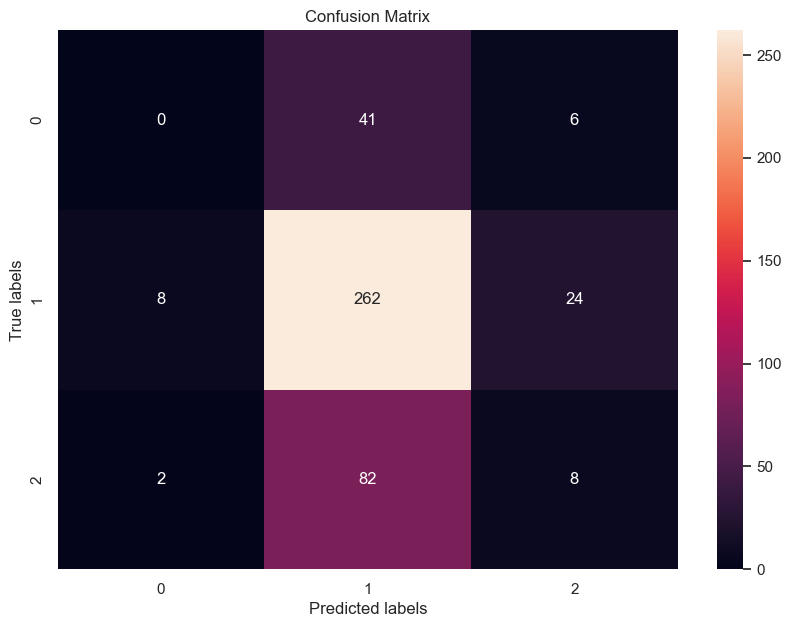

In [37]:
cm = confusion_matrix(y, preds_roberta)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

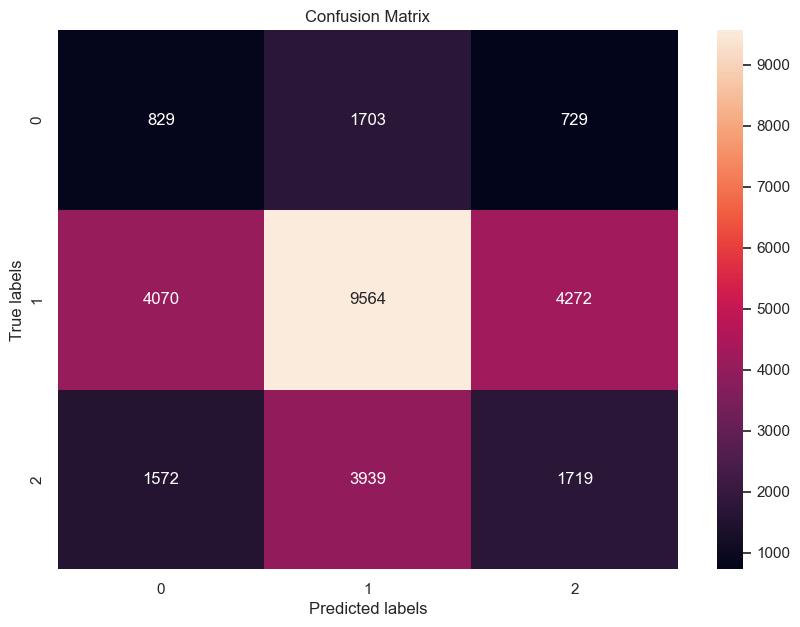

In [99]:
cm = confusion_matrix(y, preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

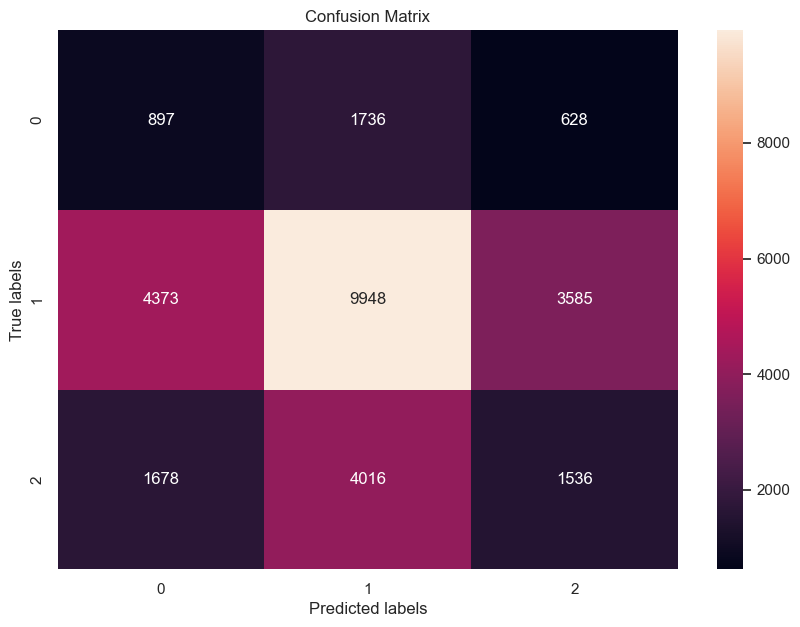

In [100]:
cm = confusion_matrix(y, submuestra_df.predicted_finbertTone)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Predict sentiment for every sentence
### Define Encoder, Model and Prediction functions

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=48):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))

    return text_ids, pad_masks, segment_ids

In [ ]:
def predict(text, model):
    """
    Make a prediction on a single sentence.
    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
    Returns
    -------
        pred : Prediction vector
    """
    text_ids, pad_masks, segment_ids = bert_encoder(text)

    text_ids = torch.tensor(text_ids).unsqueeze(0)
    pad_masks = torch.tensor(pad_masks).unsqueeze(0)
    segment_ids = torch.tensor(segment_ids).unsqueeze(0)

    outputs = model(text_ids, pad_masks, segment_ids)[0].detach()
    pred = F.softmax(outputs, dim=1).cpu().numpy()

    return pred

In [ ]:
# Check
text = "Google is working on self driving cars, I'm bullish on $goog"
predict(text, model)

array([[0.16328089, 0.81788   , 0.01883917]], dtype=float32)

In [ ]:
def score_text(df, text_column, model):
    class_names = ['Negative', 'Neutral', 'Positive']
    scores = []
    predicts = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        score = predict(row[text_column], model)
        scores.append((score[0]))
        predicts.append(class_names[int(np.argmax(score))])

    df['score'] = scores
    df['prediction'] = predicts

    return df

### Run Prediction

In [ ]:
doc_types = train_sent_df['type'].unique().tolist()
doc_types

['statement',
 'minutes',
 'presconf_script',
 'speech',
 'testimony',
 'meeting_script']

In [ ]:
result_df = pd.DataFrame([], columns=train_df.columns)
for doc_type in doc_types:
    print('Processing {}...'.format(doc_type))
    train_sample = train_sent_df.loc[(train_sent_df['type']==doc_type)]
    res = score_text(train_sample, 'text', model)
    result_df = pd.concat([result_df, res], axis=0)

result_df.head()

Processing statement...



Processing minutes...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':



Processing presconf_script...



Processing speech...



Processing testimony...



Processing meeting_script...


In [ ]:
result_df = pd.concat([result_df, pd.get_dummies(result_df['prediction'])], axis=1)
result_df.head()

In [ ]:
result_df

In [ ]:
train_result = train_df.copy()
train_result['key2'] = train_result['type'] + "_" + train_result['key'].map(str)
result_df['key2'] = result_df['type'] + "_" + result_df['key'].map(str)

neg = result_df.groupby(by=['key2'])['Negative'].sum()
neu = result_df.groupby(by=['key2'])['Neutral'].sum()
pos = result_df.groupby(by=['key2'])['Positive'].sum()

train_result = train_result.merge(neg, on='key2', how='left')
train_result = train_result.merge(neu, on='key2', how='left')
train_result = train_result.merge(pos, on='key2', how='left')

train_result['sentiment'] = (train_result['Positive'] - train_result['Negative'])
train_result.sort_values(['type', 'next_meeting'], inplace=True)

print("The number of records: ", train_result.shape[0])
print("Sentiment is null: ", train_result['sentiment'].isnull().sum())
train_result.tail()

In [ ]:
def get_doctype_df(df, doc_type):
    if doc_type == 'all':
        new_df = df
    else:
        new_df = df.loc[df['type']==doc_type]
    new_df = new_df.groupby(by=['next_meeting', 'next_decision', 'next_rate'])['Negative', 'Neutral', 'Positive', 'sentiment'].sum()
    new_df.reset_index(level=[1,2], inplace=True)
    new_df.sort_index(inplace=True)
    new_df['next_rate_change'] = new_df['next_rate'] - new_df['next_rate'].shift(1)
    new_df['sentiment_pct'] = new_df['sentiment'] / (new_df['Positive'] + new_df['Negative'])
    new_df['sentiment_chg'] = new_df['sentiment'] - new_df['sentiment'].shift(1)
    return new_df

In [ ]:
stmt_df = get_doctype_df(train_result, 'statement')
minutes_df = get_doctype_df(train_result, 'minutes')
presconf_df = get_doctype_df(train_result, 'presconf_script')
m_script_df = get_doctype_df(train_result, 'meeting_script')
speech_df = get_doctype_df(train_result, 'speech')
testimony_df = get_doctype_df(train_result, 'testimony')
all_df = get_doctype_df(pd.concat([stmt_df, minutes_df, presconf_df, m_script_df, speech_df, testimony_df], axis=0), 'all')
all_df

In [ ]:
# Show corelations to target
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

def plot_sentiment(df, doc_type, sent_column):
    fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(15,10), gridspec_kw={'height_ratios': [3, 1]})
    sns.lineplot(y=df[sent_column], x=df.index.get_level_values(0), ax=ax1)
    ax1.set_xlim('1992-01-01', '2020-06-01')
    ax1.set_ylabel('Sentiment: {}'.format(sent_column))
    ax1.set_xlabel('Year')
    ax1.fill_between(df.index.get_level_values(0), 0, df[sent_column], where=df[sent_column] > 0, facecolor='blue', alpha=0.2)
    ax1.fill_between(df.index.get_level_values(0), 0, df[sent_column], where=df[sent_column] < 0, facecolor='red', alpha=0.2)
    ax12 = ax1.twinx()
    sns.lineplot(y=df['next_rate'].fillna(0), x=df.index.get_level_values(0), ax=ax12, color='green')
    #ax12.yaxis.grid(True, which='major')
    ax12.set_ylim(-4,8)
    ax12.legend("Rate", loc='upper right')
    align_yaxis(ax1, 0, ax12, 0)
    arrow_style = dict(facecolor='black', shrink=0.05)
    ax12.annotate('QE1', xy=('2008-11-25', -2.5), xytext=('2008-11-25', -3.5), size=12, ha='right', arrowprops=arrow_style)
    ax12.annotate('QE1+', xy=('2009-03-18', -2), xytext=('2009-03-18', -3), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('QE2', xy=('2010-11-03', 0), xytext=('2010-11-03', -1), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('QE2+', xy=('2011-09-21', -2), xytext=('2011-09-21', -3), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('QE3', xy=('2012-09-13', -2), xytext=('2012-09-13', -3), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('Tapering', xy=('2013-12-18', 0), xytext=('2013-12-18', -2), size=12, ha='center', arrowprops=arrow_style)


    plt.title('Net sentiment over years with the next FED target rate', fontsize=16)

    corr_columns = ['sentiment', 'sentiment_pct', 'sentiment_chg', 'next_decision', 'next_rate_change', 'next_rate']
    sns.heatmap(df[corr_columns].astype(float).corr().iloc[:3], annot=True, fmt=".2f", ax=ax2, cmap= 'coolwarm', center=0, vmin=-1, vmax=1)
    ax2.set_title("Correlation", fontsize=16)

    plt.suptitle("Doc Type: {}".format(doc_type), fontsize=16)
    plt.show()

In [ ]:
plot_sentiment(all_df, 'All', 'sentiment')

In [ ]:
plot_sentiment(stmt_df, 'Statement', 'sentiment')

In [ ]:
plot_sentiment(minutes_df, 'Minutes', 'sentiment')

In [ ]:
plot_sentiment(presconf_df, 'Press Conference Script', 'sentiment')

In [ ]:
plot_sentiment(m_script_df, 'Meeting Script', 'sentiment')

In [ ]:
plot_sentiment(speech_df, 'Speech', 'sentiment')

In [ ]:
plot_sentiment(testimony_df, 'Testimony', 'sentiment')

Looking at the result, it seems Sentiment and Minutes have a certain correlation with FED Rate up and down, whereas Speech has little to do with it.

## Save Data

In [ ]:
def save_data(df, file_name, dir_name=train_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [ ]:
# Save text data
save_data(result_df, 'sentiment_bert_result')
save_data(all_df, 'sentiment_bert_all')
save_data(stmt_df, 'sentiment_bert_stmt')
save_data(minutes_df, 'sentiment_bert_minutes')
save_data(presconf_df, 'sentiment_bert_presconf')
save_data(m_script_df, 'sentiment_bert_m_script')
save_data(speech_df, 'sentiment_bert_speech')
save_data(testimony_df, 'sentiment_bert_testimony')

## Model and Train

In [ ]:
# Load data
file = open(train_dir + 'train_df.pickle', 'rb')
train_df = pickle.load(file)
file.close()
print(train_df.shape)

In [ ]:
train_df.drop(columns=['statement', 'minutes', 'presconf_script', 'speech', 'testimony', 'text',
                      'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
                       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
                       'tfidf_StrongModal', 'tfidf_Constraining'], inplace=True)

#train_df.drop(columns=['tone','cos_sim_Negative',
#       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
#       'cos_sim_StrongModal', 'cos_sim_Constraining'], inplace=True)

In [ ]:
# Use Statement Score and Minutes Score (Sentiment count, net score and change from the previous meeting) as inputs
train_df = train_df.merge(stmt_df[['Negative', 'Neutral', 'Positive', 'sentiment', 'sentiment_chg']], left_index=True, right_index=True, how='left')
train_df = train_df.merge(minutes_df[['Negative', 'Neutral', 'Positive', 'sentiment', 'sentiment_chg']], left_index=True, right_index=True, how='left', suffixes=('_stmt', '_minutes'))
train_df

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer

import scikitplot as skplt

In [ ]:
# Check the imputation
data = train_df.values
Xtmp, y1 = np.array(data[:, 1:], dtype=np.float64), np.array(data[:, 0], dtype=np.int64)+1
print('The number of training data: %d' % len(Xtmp))
print('Missing: %d' % sum(np.isnan(Xtmp).flatten()))
imputer = SimpleImputer(strategy='mean')
imputer.fit(Xtmp)
X1 = imputer.transform(Xtmp)
print('\nImputed:')
print('The number of training data: %d' % len(X1))
print('Missing: %d' % sum(np.isnan(X1).flatten()))

data2 = train_df.dropna().values
X2, y2 = np.array(data2[:, 1:], dtype=np.float64), np.array(data2[:, 0], dtype=np.int64)+1
print('\nDropped:')
print('The number of training data: %d' % len(X2))
print('Missing: %d' % sum(np.isnan(X2).flatten()))

In [ ]:
# Check the pipeline with imputation
model = RandomForestClassifier()
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Random Forest
scores = cross_val_score(pipeline, Xtmp, y1, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
scores = cross_val_score(pipeline, Xtmp, y1, scoring='f1_macro', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [ ]:
random_state = 42
#kfold = StratifiedKFold(n_splits=10, random_state=random_state)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
imputer = SimpleImputer(strategy='mean')
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state)))
classifiers.append(("ExtraTrees", ExtraTreesClassifier(random_state=random_state)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("Perceptron", Perceptron()))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("SGD", SGDClassifier()))

cv_results = []
classifier_name = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier[1], X1, y1, scoring=["accuracy", "f1_macro"], cv=kfold, n_jobs=-1))
    classifier_name.append(classifier[0])

cv_acc_means = []
cv_acc_std = []
cv_f1_means = []
cv_f1_std = []
for cv_result in cv_results:
    cv_acc_means.append(cv_result['test_accuracy'].mean())
    cv_acc_std.append(cv_result['test_accuracy'].std())
    cv_f1_means.append(cv_result['test_f1_macro'].mean())
    cv_f1_std.append(cv_result['test_f1_macro'].std())

cv_res = pd.DataFrame({"Algorithm": classifier_name,
                       "CVAccMeans":cv_acc_means,
                       "CVAccErrors": cv_acc_std,
                       "CVf1Means":cv_f1_means,
                       "CVf1Errors": cv_f1_std}).sort_values(by='CVAccMeans', ascending=False)

cv_res

In [ ]:
fig, ax = plt.subplots(figsize=(17,10))
tidy = cv_res[['Algorithm', 'CVAccMeans', 'CVf1Means']].melt(id_vars='Algorithm').rename(columns=str.title)
sns.barplot(x='Algorithm', y='Value', hue='Variable', data=tidy, ax=ax, **{'yerr':[cv_acc_std, cv_f1_std]})
sns.despine(fig)
ax.set_xlabel("Algorithm", size=14)
ax.set_ylabel("Score", size=14)
#ax.legend(['Accuracy', 'F1 Score'])
ax.set_title("Cross validation scores", size=16)
for item in ax.get_xticklabels():
    item.set_rotation(25)

In [ ]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose,
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)

    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']

    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)

    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)

        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)

        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)

        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'],
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)

        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'],
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)

        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes,
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes,
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")

        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes,
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes,
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)

        plt.tight_layout(pad=3.0)
        plt.show()

        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)

        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names,
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)

        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names,
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)

        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names,
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)

        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names,
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)

        plt.tight_layout(pad=3.0)
        plt.show()

    return model


In [ ]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [ ]:
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X1, y1, test_size=0.2, shuffle=True)

In [ ]:
# Define Classifier
DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=rand_seed)

#Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 100, 20, dtype=int),
              'base_estimator__criterion': ['gini'],
              'base_estimator__splitter': ['random'],
              'algorithm': ['SAMME'],
              'learning_rate': [0.0001]}

ada_model = train_grid_search(ada_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ada_best = ada_model.best_estimator_

In [ ]:
# Define Classifier
DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=rand_seed)
#ExtraTrees
ext_clf = ExtraTreesClassifier()
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 200, 10, dtype=int),
              'min_samples_split': [4],
              'min_samples_leaf': [8],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

ext_model = train_grid_search(ext_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ext_best = ext_model.best_estimator_

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 10, dtype=int),
              'min_samples_split': [8],
              'min_samples_leaf': [8],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

In [ ]:
# Gradient boosting
gb_clf = GradientBoostingClassifier(random_state=2)

# Perform Grid Search
param_grid = {'n_estimators': [1, 20, 50, 80, 130, 200, 300, 400],
              'min_samples_leaf': [16],
              'max_features': [0.8],
              'max_depth': [4],
              'loss': ['deviance'],
              'learning_rate': [0.05]}

gb_model = train_grid_search(gb_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
gb_best = gb_model.best_estimator_

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),
                     ("ExtraTrees", ext_best),
                     ("RandomForest", rf_best),
                     ("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_df.columns[indices][:40], x=classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),
                     ("ExtraTrees", ext_best),
                     ("RandomForest", rf_best),
                     ("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_df.columns[indices][:40], x=classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [ ]:
test_ada = pd.Series(ada_best.predict(X_test), name="Ada")
test_ext = pd.Series(ext_best.predict(X_test), name="ExtC")
test_rf = pd.Series(rf_best.predict(X_test), name="RFC")
test_gb = pd.Series(gb_best.predict(X_test), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_ada, test_ext, test_rf, test_gb],axis=1)

g = sns.heatmap(ensemble_results.corr(),annot=True, cmap="coolwarm", center=0.7)

In [ ]:
# The same including all the other classifiers
test_resuts = []

for classifier in classifiers:
    estimator = classifier[1].fit(X_train, Y_train)
    test_resuts.append(pd.Series(estimator.predict(X_test), name=classifier[0]))

base_results = pd.concat(test_resuts, axis=1)

plt.figure(figsize=(20,10))
g = sns.heatmap(base_results.corr(),annot=True, cmap="coolwarm", center=0.7)

In [ ]:
# Voting Classifier with "soft" to take all the probability into account
voting_best = VotingClassifier(estimators=[('adac', ada_best),
                                           ('extc', ext_best),
                                           ('rfc', rf_best),
                                           ('gbc', gb_best)], voting='soft', n_jobs=-1)

# # Voting Classifier with "soft" to take all the probability into account
# voting_base = VotingClassifier(estimators=classifiers, voting='soft', n_jobs=4)

voting_best.fit(X_train, Y_train)

In [ ]:
# Predict
voting_pred_train = voting_best.predict(X_train)
voting_pred_test = voting_best.predict(X_test)

acc, f1 = metric(Y_train, voting_pred_train)
logger.info('Train - acc: %.8f, f1: %.8f' % (acc, f1))

acc, f1 = metric(Y_test, voting_pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))